# Qubit calibration code

Dec 2022
João Henrique O. Fontes

In [930]:
from qick import *
from qick.averager_program import *
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import csv
from datetime import date
from scipy.optimize import curve_fit
from scipy.optimize import leastsq,minimize
from scipy import stats
from sklearn import svm
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [931]:
soc = QickSoc()
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

### Qubit+Readout  DAC channel = 2_230
### ADC channel = 0_226

In [932]:
hw_cfg={
    
    #See previous cell for correspondence between DAC number and tile
    
    "dc_ch":6,
    "qubit_ch":2
    }

readout_cfg={
    
    #Each clock tick is about 2.1 nanoseconds
    
    "readout_length":1000, # [Clock ticks]
    "res_length":soccfg.us2cycles(2.15, gen_ch=2), # [Clock ticks]
    "f_res":6792.4, # [MHz]
    "res_phase": 0, # [degrees]
    "adc_trig_offset": 50, # [Clock ticks]
    "res_gain":1890, # [a.u.]
    "drive_ro_delay":soccfg.us2cycles(0.05, gen_ch=2), # [Clock ticks]
    "res_sigma":soccfg.us2cycles(1.0, gen_ch=2), # [Clock ticks]
    }

qubit_cfg={
    "pulse_length":soccfg.us2cycles(0.05, gen_ch=2), # [Clock ticks]
    "pi_gain": 14240, # [a.u.]
    "pi2_gain": 7120, # [a.u.]
    "f_ge":5552.748164320409-0.013150979583996802, # [MHz]
    "relax_delay":80, # [Clock ticks]
    "delta":-224.852, # qubit anharmonicity [MHz]
    "sigma":soccfg.us2cycles(0.128, gen_ch=2), # [Clock ticks]
    "alpha":0, # DRAG parameter
    "threshold":None, # Run cell below
    "phase":0 # Run cell below
    }

dc_cfg={
    "dc_offset": [0, 0, 0, 0, 0, 0, -0.02] #in V, for each of the outputs
    "gain2dc": [0, 0, 0, 0, 0, 0, -0.22] #in V/1000a.u., for each of the outputs
}

# 

## Helper functions

In [408]:
def plotsave2d(plot, save, title, trial, xvar, xvarname, yvar, yvarname, zdata, zdataname, **kwargs):
        
        """
        generic plotting function for 2 sweep variables + data variable
        
        :param plot: if True, shows a plot
        :param save: if True, saves data as .csv file, and it plot is also True, as a .pdf image
        :param title: string with the name of the experiment (e.g. Length Rabi)
        :param trial: additional information in the name of the experiment to be saved, if none, it's '01'
        :param xvar: the variable on the x axis
        :param xvarname: name of the x variable to be shown on the plot
        :param yvar: the variable on the y axis
        :param yvarname: name of the y variable to be shown on the plot
        :param zdata: the actual data to be plotted
        :param zdataname: name of z data to be shown on the plot
        :param **kwargs: any additional information you want to be saved into the .csv file
            (e.g. Reps: "200", Shape: "square pulse")
            
        """
        
        if plot is not None and plot:
            pcm=plt.pcolormesh(xvar, yvar, zdata)
            plt.xlabel(xvarname)
            plt.ylabel(yvarname)
            plt.colorbar(pcm, label=zdataname)
            plt.title(title)
            
        if save is not None and save:
                today=date.today()
                if trial is None:
                    trial="01"
                if plot is not None and plot:
                    plt.savefig('images/Stark-{}-{}-{}.pdf'.format(title, today, trial))
                
                with open('measurement_data/Stark-{}-{}-{}.csv'.format(title, today, trial), 'w', encoding='UTF-8') as f:
    
                    writer = csv.writer(f)
                    writer.writerows([[title],[]])
                    for key, value in kwargs.items():
                        writer.writerow(["%s: %s" % (key, value)])
                    writer.writerow([])
                    
                df=pd.DataFrame(zdata, index=yvar, columns=xvar)
                df.to_csv('measurement_data/Stark-{}-{}-{}.csv'.format(title, today, trial), mode='a', header=True)

In [409]:
def plotsave1d(plot, save, title, trial, xvar, xvarname, ydata, ydataname, fitfunc=None, **kwargs):

        """
        generic plotting function for 1 sweep variable + data variable
        
        :param plot: if True, shows a plot
        :param save: if True, saves data as .csv file, and it plot is also True, as a .pdf image
        :param title: string with the name of the experiment (e.g. Length Rabi)
        :param trial: additional information in the name of the experiment to be saved, if none, it's '01'
        :param xvar: the variable on the x axis
        :param xvarname: name of the x variable to be shown on the plot
        :param ydata: the actual data to be plotted
        :param ydataname: name of y data to be shown on the plot
        :param fitfunc: fit function to be plotted over the data, needs to be an array with the same length as xvar
        :param **kwargs: any additional information you want to be saved into the .csv file
            (e.g. Reps: "200", Shape: "square pulse")
            
        """
        
        if plot is not None and plot:
            plt.plot(xvar, ydata, 'o-')
            if fitfunc is not None:
                plt.plot(xvar, fitfunc, 'k--')
            plt.xlabel(xvarname)
            plt.ylabel(ydataname)
            plt.title(title)
            
        if save is not None and save:
                today=date.today()
                if trial is None:
                    trial="01"
                if plot is not None and plot:
                    plt.savefig('images/Stark-{}-{}-{}.pdf'.format(title, today, trial))
                
                with open('measurement_data/Stark-{}-{}-{}.csv'.format(title, today, trial), 'w') as f:
    
                    writer = csv.writer(f)
                    writer.writerows([[title],[]])
                    for key, value in kwargs.items():
                        writer.writerow(["%s: %s" % (key, value)])
                    writer.writerow([])
                    
                df=pd.DataFrame(ydata, index=xvar)
                df.to_csv('measurement_data/Stark-{}-{}-{}.csv'.format(title, today, trial), mode='a', header=False)

In [934]:
class IQProgram(AveragerProgram):
    """
    Function to collect the IQ data of a number of individual shots, given by reps
    """
    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2)
        for ch in [0]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        self.r_rp=self.ch_page(cfg["qubit_ch"])
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")
        
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["qubit_length"], sigma=cfg["qubit_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])

        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style='arb', waveform="drive", phase=0, freq=f_ge, gain=cfg["start"])
        self.pulse(ch=cfg["qubit_ch"])
        self.sync_all(self.cfg["drive_ro_delay"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style='flat_top', waveform='measure', freq=f_res, 
                                 phase=0, 
                                 gain=cfg["res_gain"], length=cfg["res_length"])
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"])
        
        self.pulse(ch=cfg["qubit_ch"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))
        
    def acquire(self,soc, load_pulses=True, progress=False, debug=False):
        super().acquire(soc, load_pulses=load_pulses, progress=progress, debug=debug)
        return self.collect_shots()
        
    def collect_shots(self):
        shots_i0=self.di_buf[0]/self.cfg['readout_length']
        shots_q0=self.dq_buf[0]/self.cfg['readout_length']
        return shots_i0,shots_q0

## Implement save

In [935]:
def IQblobs(reps, ro_feats=None, drive_feats=None, plot=None, save=None, trial=None, collect=None):
    
    """
    Returns the IQ data of a number of individual shots
    :param reps: number of data points
    :param ro_feats: list with the readout pulse parameters. If none, it just uses the default configs.
        list elements should be given in the order: [length (us), ramp length (us), frequency (MHz), gain (a.u.)]
    :param drive_feats: list with the drive pulse parameters. If none, it just uses the default configs.
        list elements should be given in the order: [DRAG parameter, gain (a.u.), length (us)]
    :param plot: if True, plots the data
    :param save: if True, saves the data
    :param collect: if True, returns the data
    """
    
    expt_cfg={
            "start":0, "step":pi_gain, "expts":2, "reps":reps,
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}
    if ro_feats is not None:
        config["res_length"]=soccfg.us2cycles(ro_feats[0])
        config["res_sigma"]=soccfg.us2cycles(ro_feats[1])
        config["f_res"]=ro_feats[2]
        config["res_gain"]=int(ro_feats[3])
    if drive_feats is not None:  
        config["alpha"]=drive_feats[0]
        config["pi_gain"]=drive_feats[1]
        config["qubit_length"]=soccfg.us2cycles(drive_feats[2])
    
    iq = IQProgram(soccfg, config)
    avgi0, avgq0 = iq.acquire(soc, load_pulses=True, progress=False,debug=False)
    config["start"]=pi_gain
    iq = IQProgram(soccfg, config)
    avgi1, avgq1 = iq.acquire(soc, load_pulses=True, progress=False,debug=False)
    
    if plot is not None and plot:
        plt.scatter(avgi1,avgq1)
        plt.scatter(avgi0,avgq0)
        plt.axis("equal")
    
    if collect:
        return avgi0, avgq0, avgi1, avgq1

In [936]:
def hist(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='lower right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        axs[2].set_xlabel('I(a.u.)')       
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind]
    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

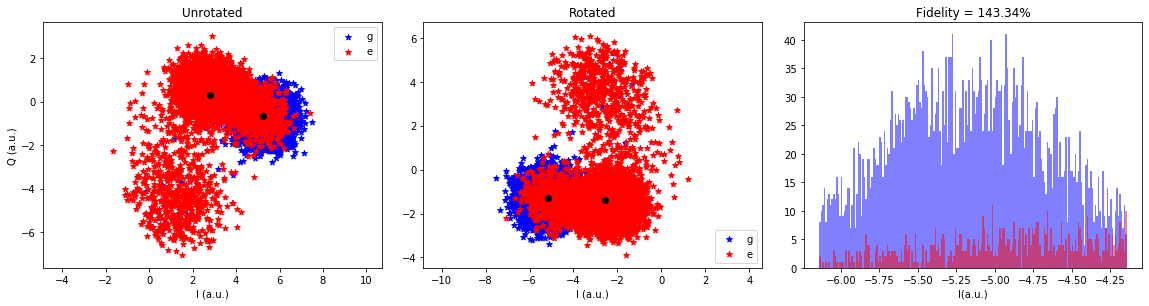

In [937]:
def find_threshold(n_datapoints, plot=None):
    """
    Subsitutes the value of Threshold and phase in config
    :param n_datapoints: number of datapoints
    :param plot: if True, plots the data
    """
    fid, threshold, theta = hist(data=IQblobs(5000, plot=False, collect=True), plot=plot)
    qubit_cfg["threshold"]=threshold
    qubit_cfg["phase"]=-theta*180/np.pi

In [ ]:
find_threshold(5000)

In [410]:
"""Fit functions"""

def sinfunc(x,A,W,P,L):
    return np.sin(W*x+P)*A+L

def exp_decay(x, A, B, T):
    return A*np.exp(-x/T)+B

def p_decay(x, A, P, B):
    return A*np.power(P, x)+B

def t2fit(x, A, W, T, B):
    return np.exp(-x/T)*np.cos(W*x)*A+B

# 

# 

# 

# 

# 

# 

# 

# 

# 

## Send continuous signal

In [384]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["qubit_ch"] #defines the output

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #nqz sets the Nyquist zone. Preferrably, use nqz=1 for pulses under 3440MHz
        
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch) #converts frequency to generator frequency

        self.set_pulse_registers(ch=res_ch, style="const", length=cfg["length"], freq=freq, phase=0, gain=cfg["pulse_gain"]) #sets the pulse to be played
        
        self.synci(200) #small delay to synchronize everything
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"]) #sends the pulse
        self.wait_all() #waits a specified number of clock ticks. Here, it's none.

In [387]:
def ContinuousSignal(freq, gain):
    """Function to send a continuous signal of set frequency and gain
    
    :param freq: frequency [MHz]
    :param gain: signal gain [a.u.]
    
    """ 

    config={"qubit_ch":6,
            "reps":1,
            "relax_delay":1.0,
            "length":1000,
            "pulse_gain":int(gain),
            "pulse_freq":freq,
            "soft_avgs":1
           }

    prog =LoopbackProgram(soccfg, config)

    avgq, avgi = prog.acquire(soc, load_pulses=True, progress=True, debug=False)

In [398]:
ContinuousSignal(500,10000)

  0%|          | 0/1 [00:00<?, ?it/s]

In [395]:
soc.reset_gens() #stop the signal

# 

# 

# 

# 

# 

# 

# 

# 

## Finding the frequency of the readout resonator

In [982]:
class SingleToneSpectroscopyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg 
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2)
        
        
        self.r_rp=self.ch_page(self.cfg["qubit_ch"])
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain") #Declare the address where the value of gain will be registered for the sweep
        
        #Declare readout channels
        for ch in [0]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["frequency"], gen_ch=cfg["qubit_ch"])
            
        freq = self.freq2reg(cfg["frequency"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        
        #Creates the waveform for the readout pulse
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])
            
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=freq, length=cfg["res_length"], 
                                 phase=0, gain=cfg["start"])
        
        self.synci(200)
    
    def body(self):
        cfg=self.cfg
        
        #Triggers waveform acquisition
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"])
        
        self.pulse(ch=cfg["qubit_ch"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))
        
    def update(self):
        self.mathi(self.r_rp, self.r_gain, self.r_gain, '+', self.cfg["step"])

In [983]:
def ROFrequency(ro_length, f_start, f_stop, f_expts, g_start, g_stop, g_expts, plot=None, save=None, trial=None, collect=None):
    
    """
    finds the frequency of the readout resonator
    
    :param ro_length: length of the probe pulse [us]
    :param f_start: start frequency [MHz]
    :param f_stop: stop frequency [MHz]
    :param f_expts: # of frequency points (int)
    :param g_start: start gain [a.u.]
    ...
    
    :params plot, save, trial: see plotsave2d function above
    :param collect: if True, returns the data
    
    """
    
    expt_cfg={"reps":50, "relax_delay":10, "f_start":f_start, "f_stop":f_stop, "f_expts":f_expts, 
              "start":g_start, "step":int((g_stop-g_start)/g_expts), "expts":g_expts}

    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}
    
    config["res_length"]=soccfg.us2cycles(ro_length,gen_ch=2) #converts length to clock cycles
    f_range=np.linspace(config["f_start"], config["f_stop"], config["f_expts"])

    amps=[]
    for i in tqdm(f_range):
        config["frequency"]=i,
        rspec=SingleToneSpectroscopyProgram(soccfg, config)
        expt_pts, avgi,avgq=rspec.acquire(soc, load_pulses=True, progress=False) #calls the previous cell with the actual pulse sequences and measurements
        amp=np.abs(avgi[0][0]+1j*avgq[0][0])
        amps.append(amp)
    
    amps=np.array(amps)
    background=np.mean(amps[0:int(f_expts/6)]) #we are interested in the relative amplitude, so we plot the data divided by the background
    
    plotsave2d(plot=plot, save=save, title="RR Spectroscopy", trial=trial, xvar=f_range,
              xvarname="Frequency (MHz)", yvar=expt_pts, yvarname="DAC Gain (a.u.)", zdata=(amps/background).T,
              zdataname="Transmission amplitude", Length=ro_length, Shape="Flat top pulse")
    
    if collect:
        return amps.T

  0%|          | 0/100 [00:00<?, ?it/s]

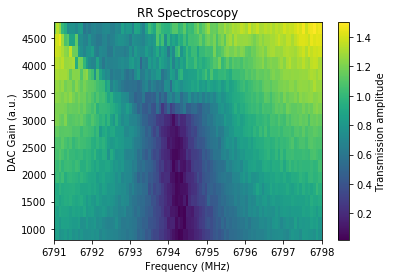

In [984]:
ROFrequency(2.0, 6791,6798,100,800,5000,20, plot=True, save=False, trial="gaussian")

# 

# 

# Finding the qubit drive frequency

In [1022]:
class PulseProbeSpectroscopyProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2)
        
        for ch in [0]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
            
             
        global freq
        freq = self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        
        global phase
        phase=self.deg2reg(cfg["phase"])
        
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["probe_length"], sigma=cfg["probe_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_DRAG(ch=cfg["qubit_ch"], name="exciter", length=cfg["pulse_length"], sigma=cfg["pulse_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])
            
        
        self.sync_all(200)
    
    def body(self):
        cfg=self.cfg
        
        #prepares the qubit into the desired state
        if cfg["state"]:
            self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=self.freq2reg(cfg["f_ge"]), 
                                 gain=cfg["pi_gain"], waveform="exciter", phase=0)
            self.pulse(ch=self.cfg["qubit_ch"])
            self.sync_all(20)
           
        #drive pulse
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=self.freq2reg(cfg["qubit_freq"], gen_ch=cfg["qubit_ch"]), 
                                 gain=cfg["qubit_gain"], waveform="drive", phase=0)
        self.pulse(ch=self.cfg["qubit_ch"], t=0)
        
        #measure pulse
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=freq, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=phase)
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"], t=int(cfg["probe_length"]+cfg["drive_ro_delay"]))
        
        self.pulse(ch=cfg["qubit_ch"], t=int(cfg["probe_length"]+cfg["drive_ro_delay"]))
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [1023]:
def QubitSpectroscopy(probe_length, gain, reps, f_start, f_stop, f_expts, state=None, plot=None, save=None, trial=None, collect=None):
    
    """
    finds the drive frequency of the qubit
    
    :param probe_length: length of the probe pulse [us]
    :param gain: gain of the probe pulse [a.u.]
    :param reps: reps to be averaged over (int)
    :param f_start: start frequency [MHz]
    :param f_stop: stop frequency [MHz]
    :param f_expts: # of frequency points (int)
    :param state: state of the qubit before probe pulse. If None or 0, it's in the ground state, if 1, it's in the excited state.
    ...
    
    :params plot, save, trial: see plotsave1d function above
    :param collect: if True, returns the data
    
    """
    
    expt_cfg={"reps": reps,"rounds":1,
              "probe_length":soccfg.us2cycles(probe_length, gen_ch=2), "qubit_gain":gain
             }

    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    amps=[]
    config["state"]=state
    for i in tqdm(np.linspace(f_start,f_stop,f_expts)):
        config["qubit_freq"]=i
        qspec=PulseProbeSpectroscopyProgram(soccfg, config)
        avgi, avgq = qspec.acquire(soc, threshold=config["threshold"], angle=None, load_pulses=True, progress=False, debug=False)
        
        amps.append(np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr)

    subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (MHz)", ylabel="Qubit Population")

    plotsave1d(plot=plot, save=save, title="Qubit Spectroscopy", trial=trial, xvar=np.linspace(f_start,f_stop,f_expts),
              xvarname="Qubit Frequency", ydata=amps, ydataname="IQ amplitude", Length=probe_length, Gain=gain, Shape="arb")
    
    if collect:
        return amps

  0%|          | 0/100 [00:00<?, ?it/s]

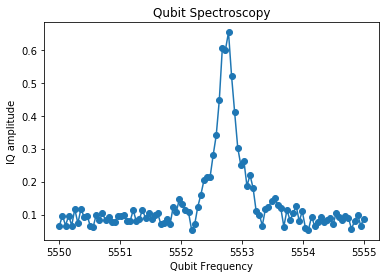

In [1031]:
QubitSpectroscopy(3.0, 200, 300, 5550, 5555, 100, plot=True, save=False, trial="actual-transition-frequency")

In [126]:
soc.reset_gens()

# 

# 

# 

# 

# 

# 

# 

## Length Rabi

In [861]:
class LengthRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        global phase
        phase=self.deg2reg(cfg["phase"])
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["qubit_length"], sigma=cfg["qubit_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])
            
        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", waveform="drive", freq=f_ge, gain=cfg["qubit_gain"], phase=0)
        self.pulse(ch=cfg["qubit_ch"], t=0)
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=phase)
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"], t=int(cfg["qubit_length"]+cfg["drive_ro_delay"]))
        
        self.pulse(ch=cfg["qubit_ch"], t=int(cfg["qubit_length"]+cfg["drive_ro_delay"]))
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [862]:
def LengthRabi(gain, start, stop, expts, reps, plot=None, save=None, trial=None, collect=None):
    
    """
    finds the length of the pi pulse with a given amplitude
    
    :param gain: gain of the drive pulse [a.u.]
    :param reps: reps to be averaged over (int)
    :param start: start length [us]
    :param stop: stop length [us]
    :param expts: # of length points (int)
    
    All lengths are increased by ~10ns, which is the minimum length
    ...
    
    :params plot, save, trial: see plotsave1d function above
    :param collect: if True, returns the data. If false, returns pi pulse length.
    
    """
    
    expt_cfg={
            "qubit_gain":gain,
            "start":start, "stop":stop, "expts":expts, "reps":reps,
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    results=[]
    for l in tqdm(np.linspace(soccfg.us2cycles(start), soccfg.us2cycles(stop), expts)+4):
        config["qubit_length"]=l

        rabi=LengthRabiProgram(soccfg, config)
        avgi,avgq = rabi.acquire(soc, threshold=config["threshold"], load_pulses=True, progress=False,debug=False)
        results.append(np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr)
    
    #automatic fit
    minvalue=np.min(results)
    maxvalue=np.max(results)
    amplitude=maxvalue-minvalue
    maxsin=np.where(results>maxvalue-0.2*amplitude)[0][0]
    try:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][np.where(results<minvalue+0.2*amplitude)[0]>maxsin][0]
    except:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][0]

    p_guess = [amplitude/2,np.pi/(minsin-maxsin),np.pi/2,np.mean(results)]
    p_opt, p_cov = curve_fit(sinfunc, np.arange(expts), results, p0 = p_guess)
    p_err = np.sqrt(np.diag(p_cov))

    fitfunc=sinfunc(np.arange(expts),p_opt[0],p_opt[1],p_opt[2],p_opt[3])
    fitvalues=p_opt
    fitvalueserr=p_err
    
    plotsave1d(plot=plot, save=save, title="Length Rabi", trial=trial, xvar=np.linspace(start,stop,expts)*1000+9.3,
              xvarname="Pulse length (ns)", ydata=results,ydataname="IQ amplitude", fitfunc=fitfunc, Gain=gain, Shape="square pulse",
              Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)

    step=np.linspace(start, stop, expts)[1]-np.linspace(start, stop, expts)[0]
    pipulse = np.pi/p_opt[1]*step
    
    if collect:
        return results
    else:
        return pipulse

  0%|          | 0/200 [00:00<?, ?it/s]

0.060314254159799324

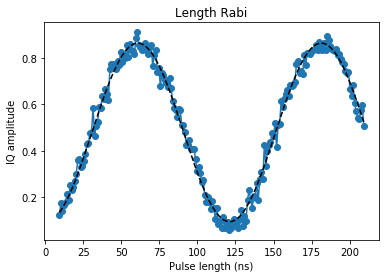

In [863]:
LengthRabi(12000,0,0.2,200,200, plot=True)['pipulse']

In [504]:
def length_deviation(x):
    return (soccfg.cycles2us(soccfg.us2cycles(x))-x)/x

In [530]:
length_deviation(0.023251)

2.0992440673307186e-05

# 

# 

# 

# Amplitude Rabi

In [610]:
class AmplitudeRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        global phase
        phase=self.deg2reg(cfg["phase"])
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["qubit_length"], sigma=cfg["qubit_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])
            
        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", waveform="drive", freq=f_ge, gain=cfg["qubit_gain"], phase=0)
        self.pulse(ch=cfg["qubit_ch"], t=0)
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=phase)
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"], t=int(cfg["qubit_length"]+cfg["drive_ro_delay"]))
        
        self.pulse(ch=cfg["qubit_ch"], t=int(cfg["qubit_length"]+cfg["drive_ro_delay"]))
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [616]:
def AmplitudeRabi(length, start, stop, expts, reps, plot=None, save=None, trial=None, collect=None):
    
    """
    finds the amplitude of the pi pulse with a given length
    
    :param length: length of the drive pulse [us]
    :param reps: reps to be averaged over (int)
    :param start: start gain [a.u.]
    :param stop: stop gain [a.u.]
    :param expts: # of gain points (int)
    
    ...
    
    :params plot, save, trial: see plotsave1d function above
    :param collect: if True, returns the data. If false, returns pi pulse amplitude.
    
    """
    
    expt_cfg={
            "qubit_length":soccfg.us2cycles(length), "reps":reps
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    results=[]
    for l in tqdm(np.linspace(start, stop, expts)):
        config["qubit_gain"]=int(l)
        rabi=AmplitudeRabiProgram(soccfg, config)
        avgi,avgq = rabi.acquire(soc, threshold=config["threshold"], load_pulses=True, progress=False,debug=False)
        results.append(np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr)
    
    minvalue=np.min(results)
    maxvalue=np.max(results)
    amplitude=maxvalue-minvalue
    maxsin=np.where(results>maxvalue-0.2*amplitude)[0][0]
    try:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][np.where(results<minvalue+0.2*amplitude)[0]>maxsin][0]
    except:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][0]

    p_guess = [amplitude/2,np.pi/(minsin-maxsin),-np.pi/2,np.mean(results)]
    p_opt, p_cov = curve_fit(sinfunc, np.arange(expts), results, p0 = p_guess)
    p_err = np.sqrt(np.diag(p_cov))

    fitfunc=sinfunc(np.arange(expts),p_opt[0],p_opt[1],p_opt[2],p_opt[3])
    fitvalues=p_opt
    fitvalueserr=p_err
    
    plotsave1d(plot=plot, save=save, title="Amplitude Rabi", trial=trial, xvar=np.linspace(start, stop, expts),
               xvarname="Gain", ydata=results,ydataname="Qubit population", fitfunc=fitfunc, Length=length, Shape="square pulse",
              Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)
    
    step=(np.linspace(start, stop, expts)[100]-np.linspace(start, stop, expts)[0])/100
    pipulse = np.pi/p_opt[1]*step
    
    if collect:
        return results
    else:
        return np.abs(pipulse)

  0%|          | 0/200 [00:00<?, ?it/s]

{'pipulse': 14490.516301047632}

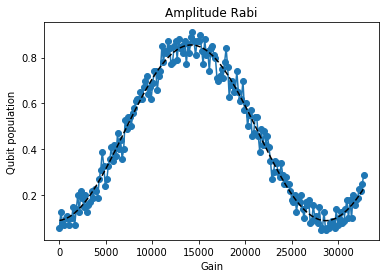

In [617]:
AmplitudeRabi(0.05, 0, 32767, 200, 100, plot=True)

# 

# 

## Pi/2 Amplitude Rabi

In [621]:
class Pi2AmplitudeRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        global phase
        phase=self.deg2reg(cfg["phase"])
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["qubit_length"], sigma=cfg["qubit_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])
            
        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", waveform="drive", freq=f_ge, gain=cfg["qubit_gain"], phase=0)
        self.pulse(ch=cfg["qubit_ch"], t=0)
        self.pulse(ch=cfg["qubit_ch"], t=int(cfg["qubit_length"]))
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=phase)
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"], t=int(2*cfg["qubit_length"]+cfg["drive_ro_delay"]))
        
        self.pulse(ch=cfg["qubit_ch"], t=int(2*cfg["qubit_length"]+cfg["drive_ro_delay"]))
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [709]:
def Pi2AmplitudeRabi(length, start, stop, expts, reps, plot=None, save=None, trial=None):
    
    """
    finds the amplitude of the pi/2 pulse with a given length
    
    :param length: length of the drive pulse [us]
    :param reps: reps to be averaged over (int)
    :param start: start gain [a.u.]
    :param stop: stop gain [a.u.]
    :param expts: # of gain points (int)
    
    ...
    
    :params plot, save, trial: see plotsave1d function above
    :param collect: if True, returns the data. If false, returns pi/2 pulse amplitude.
    
    """
    expt_cfg={
            "qubit_length":soccfg.us2cycles(length), "reps":reps
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    results=[]
    for l in tqdm(np.linspace(start, stop, expts)):
        config["qubit_gain"]=int(l)
        rabi=Pi2AmplitudeRabiProgram(soccfg, config)
        avgi,avgq = rabi.acquire(soc, threshold=config["threshold"], load_pulses=True, progress=False,debug=False)
        results.append(np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr)
        
    #automatic fit
    
    minvalue=np.min(results)
    maxvalue=np.max(results)
    amplitude=maxvalue-minvalue
    maxsin=np.where(results>maxvalue-0.2*amplitude)[0][0]
    try:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][np.where(results<minvalue+0.2*amplitude)[0]>maxsin][0]
    except:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][0]

    p_guess = [amplitude/2,np.pi/(minsin-maxsin),-np.pi/2,np.mean(results)]
    p_opt, p_cov = curve_fit(sinfunc, np.arange(expts), results, p0 = p_guess)
    p_err = np.sqrt(np.diag(p_cov))

    fitfunc=sinfunc(np.arange(expts),p_opt[0],p_opt[1],p_opt[2],p_opt[3])
    fitvalues=p_opt
    fitvalueserr=p_err
    
    plotsave1d(plot=plot, save=save, title="Pi/2 Amplitude Rabi", trial=trial, xvar=np.linspace(start, stop, expts),
               xvarname="Gain", ydata=results,ydataname="Qubit population", fitfunc=fitfunc, Length=length, Shape="gaussian pulse",
              Reps = reps, Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)
    
    step=(np.linspace(start, stop, expts)[10]-np.linspace(start, stop, expts)[0])/10
    pipulse = np.pi/p_opt[1]*step
    
    if collect:
        return results
    else:
        return np.abs(pipulse)

  0%|          | 0/200 [00:00<?, ?it/s]

{'pi2pulse': 7172.110043652122, 'pipulse': 14344.220087304244}

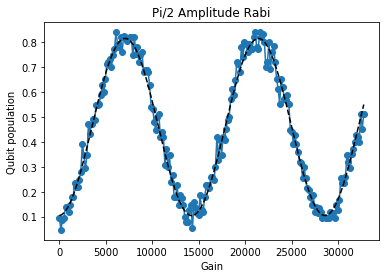

In [711]:
Pi2AmplitudeRabi(0.05, 0, 32767, 200, 150, plot=True)

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

## IQ things

In [938]:
#Haoxiong's function to calculate visibility

def maximize_visibility(I0s,Q0s,I1s,Q1s,initial_center,plot=True):
    """Find the center of the pi pulse IQ scatter data to maximize visibility."""
    I0 = np.mean(I0s)
    Q0 = np.mean(Q0s)
    def visibility(p,plot=False):
        I0s_shift = I0s - (p[0]+I0)/2.0
        Q0s_shift = Q0s - (p[1]+Q0)/2.0
        I1s_shift = I1s - (p[0]+I0)/2.0
        Q1s_shift = Q1s - (p[1]+Q0)/2.0
        angle = np.angle(-1j*p[1]-p[0]+1j*Q0+I0)
        rot_mat = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])
        IQ0s = np.dot(rot_mat,np.vstack([I0s_shift,Q0s_shift]))
        IQ1s = np.dot(rot_mat,np.vstack([I1s_shift,Q1s_shift]))
        I0_rot = IQ0s[0]
        I1_rot = IQ1s[0]
        prob0 = float(I0_rot[I0_rot<0].size)/I0_rot.size
        prob1 = float(I1_rot[I1_rot<0].size)/I1_rot.size
        if plot is True:
            y0,x0 = np.histogram(I0_rot,bins=50,normed=True)
            y1,x1 = np.histogram(I1_rot,bins=50,normed=True)
            x0 = (x0[:-1]+x0[1:])/2.0
            x1 = (x1[:-1]+x1[1:])/2.0
            probs0 = np.cumsum(y0)*(x0[1]-x0[0])
            probs1 = np.cumsum(y1)*(x1[1]-x1[0])
            x_visibility = np.linspace(min([x0[0],x1[0]]),max([x0[-1],x1[-1]]),1001)
            vis = []
            for x in x_visibility:
                prob0_fit = np.interp(x,x0,probs0,left=0,right=1)
                prob1_fit = np.interp(x,x1,probs1,left=0,right=1)
                vis.append(prob1_fit - prob0_fit)
            best_vis = np.max(vis)

            fig,ax1 = plt.subplots()
            plt.sca(ax1)
            plt.hist(I0_rot,color='b',bins=50,alpha=0.5,normed=True,label='|0>')
            plt.hist(I1_rot,color='r',bins=50,alpha=0.5,normed=True,label='|1>')
            plt.xlabel('Projection Position')
            plt.ylabel('Probability Density')
            plt.legend(loc=2)
            ax2 = ax1.twinx()
            plt.sca(ax2)
            plt.plot(x0,probs0,'b',label='|0>')
            plt.plot(x1,probs1,'r',label='|1>')
            plt.plot(x_visibility,vis,'g',label='|1>-|0>')
            plt.ylabel('Probability')
            plt.ylim([0,1])
            plt.legend(loc=6)
            plt.grid(True,which='both')
            plt.title('Best Visibility %.3f'%best_vis)
            plt.show()
        return prob1 - prob0

    def fit_func(p):
        return -visibility(p,plot=False)
    res = minimize(fit_func,initial_center,method='Nelder-Mead')
    if plot:
        visibility(res.x,plot=True)
    return -res.fun

In [939]:
def calc_visibility(n_datapoints, ro_feats=None, drive_feats=None, plot=None):
    if plot is None:
        plot = False
    a, b, c, d = IQblobs(n_datapoints, 
                         ro_feats=ro_feats, drive_feats=drive_feats, plot=False)
    initial_center=[np.mean(c),np.mean(d)]        
    return maximize_visibility(a,b,c,d, initial_center, plot=plot)

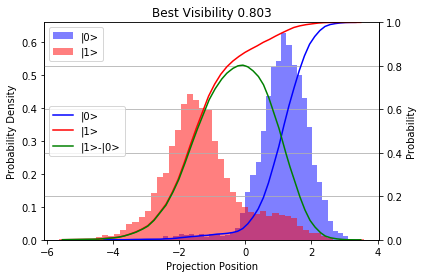

0.8022

In [941]:
calc_visibility(5000, plot=True)

## Implement save

In [732]:
def differential_evolution(n_walkers, steps, thresh, evol, bounds, params, plot=None, save=None, trial=None, collect=None):
    
    """
    Differential evolution for readout optimization, automatically updates config
    
    :param n_walkers: number of walker points
    :param steps: number of steps
    :param thresh: threshold for evolution (between 0 and 1)
    :param evol: evolution rate (between 0 and 1)
    :param bounds: (n,2) list with the initial boundaries given in the order [pulse length (us), ramp length (us),
        frequency (MHz), gain (a.u.)], each element should be [lower bound, upper bound]
    :param params: number of datapoints for visibility to be calculated over
    """
    
    bounds=np.array(bounds)
    n_features=bounds.shape[0]
    
    x = np.random.rand(n_walkers, n_features)
    x = (bounds[:,1]-bounds[:,0])*x+bounds[:,0]
    xfinal = np.copy(x).reshape(1,n_walkers,n_features)

    xvals=[calc_visibility(params, ro_feats=x[i]) for i in range(n_walkers)]
    xvalsfinal=np.copy(xvals)
    indexes = np.arange(n_walkers)
    
    for i in tqdm(range(steps)):
        
        mask = np.random.rand(n_walkers, n_features)<thresh
        rs = np.random.randint(n_features, size=n_walkers)
        rs = np.tile(np.arange(n_features), n_walkers).reshape(n_walkers, n_features)==np.array(rs).reshape(n_walkers,1)
        mask = np.logical_or(mask, rs)

        for ii in tqdm(range(n_walkers)):
            np.random.shuffle(indexes)
            r1, r2, r3 = indexes[indexes != ii][0:3]
            
            y = x[r1]+evol*(x[r2]-x[r3])

            y = y*mask[ii]+x[ii]*(1-mask[ii])
            
            yval=calc_visibility(params, ro_feats=y)
            
            if yval>xvals[ii]:
                x[ii]=y
                xvals[ii]=yval
        
        xfinal=np.concatenate((xfinal, np.array(x).reshape(1,n_walkers,n_features)))
        xvalsfinal=np.vstack((xvalsfinal, xvals))
    
    if plot:
        fig, axs = plt.subplots(5,1, figsize=(10,25))
        for i in range(steps+1):
            axs[0].scatter(np.ones(n_walkers)*i, xfinal[i,:,0], label=i)
            axs[0].set_xlabel('step')
            axs[0].set_ylabel('pulse length (us)')
            axs[1].scatter(np.ones(n_walkers)*i, xfinal[i,:,1], label=i)
            axs[1].set_xlabel('step')
            axs[1].set_ylabel('sigma length (us)')
            axs[2].scatter(np.ones(n_walkers)*i, xfinal[i,:,2], label=i)
            axs[2].set_xlabel('step')
            axs[2].set_ylabel('frequency (MHz)')
            axs[3].scatter(np.ones(n_walkers)*i, xfinal[i,:,3], label=i)
            axs[3].set_xlabel('step')
            axs[3].set_ylabel('gain (a.u.)')
            axs[4].scatter(np.ones(n_walkers)*i, xvalsfinal[i], label=i)
            axs[4].set_xlabel('step')
            axs[4].set_ylabel('visibilities')
        
        if save:
            if trial is None:
                trial='01'
            plt.savefig('images/Stark-RO-optimization-corrected-{}.png'.format(trial))
        
        readout_config["res_length"]=np.median(xfinal[-1, 0])
        readout_config["res_sigma"]=np.median(xfinal[-1, 1])
        readout_config["f_res"]=np.median(xfinal[-1, 2])
        readout_config["res_gain"]=np.median(xfinal[-1, 3])
    
    if collect:
        return xfinal[-1], xvalsfinal[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

(array([[2.14799131e+00, 1.03506995e+00, 6.79241670e+03, 1.86552642e+03],
        [2.14366617e+00, 9.89992220e-01, 6.79220402e+03, 1.98580023e+03],
        [2.13748359e+00, 1.01357291e+00, 6.79223634e+03, 1.95894014e+03],
        [2.13204120e+00, 9.83795218e-01, 6.79198692e+03, 2.11734920e+03],
        [2.14970546e+00, 1.07405795e+00, 6.79236979e+03, 1.87746587e+03],
        [2.18205531e+00, 8.70813790e-01, 6.79221968e+03, 1.97170968e+03],
        [2.16919442e+00, 1.02843156e+00, 6.79244467e+03, 1.84910668e+03],
        [2.16775020e+00, 1.03387117e+00, 6.79233821e+03, 1.90292663e+03],
        [2.11182365e+00, 1.26292031e+00, 6.79272100e+03, 1.69246076e+03],
        [2.13748359e+00, 1.01357291e+00, 6.79223634e+03, 1.95894014e+03],
        [2.13208889e+00, 1.14077893e+00, 6.79254797e+03, 1.77260711e+03],
        [2.14311068e+00, 1.12092969e+00, 6.79251910e+03, 1.79343303e+03],
        [2.16088109e+00, 8.94589009e-01, 6.79215186e+03, 2.01654844e+03],
        [2.14019573e+00, 1.08349428e+0

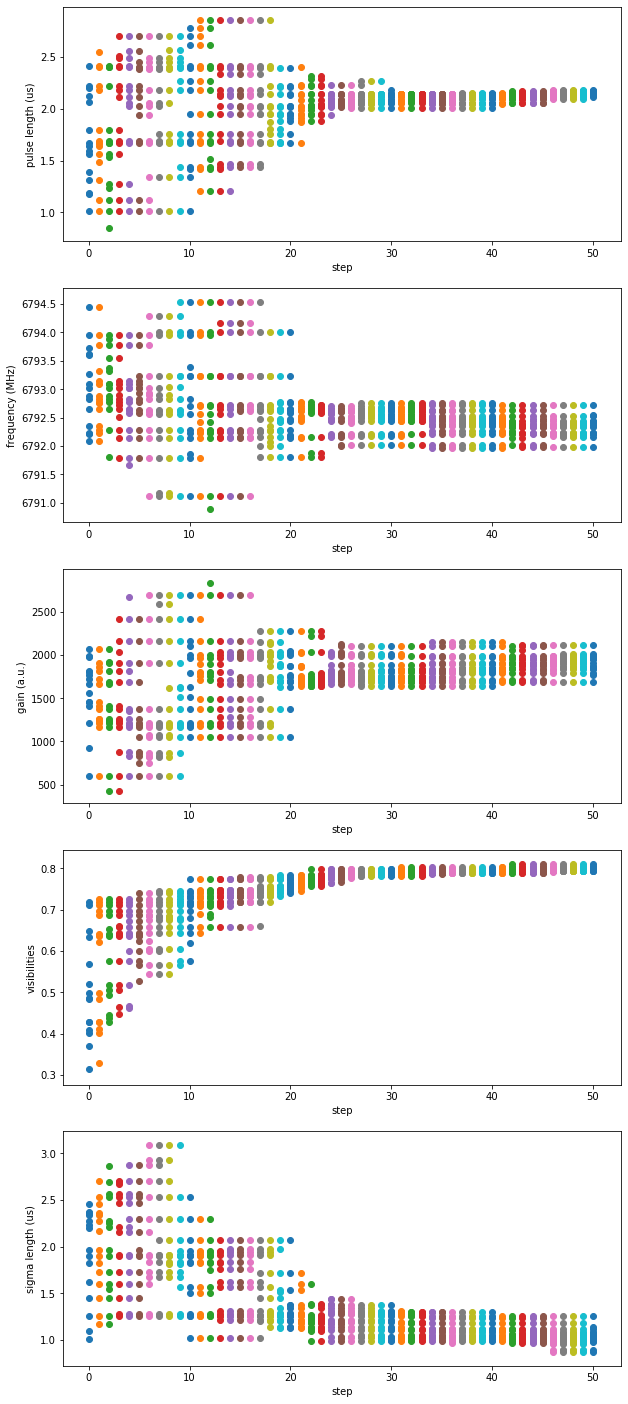

In [727]:
differential_evolution(15, 50, 0.8, 0.4, [[1, 2.5], [1, 2.5], [6792, 6794.5], [500,2200]], 5000, plot=True)

## Tuning up pi pulse (not sure if it works as desired)

In [29]:
def DRAGTuneUp(a_start, a_stop, a_expts, g_start, g_stop, g_expts, reps, plot=None, save=None, trial=None):
    
    expt_cfg={"reps":reps, "relax_delay":10, "a_start":a_start, "a_stop":a_stop, "a_expts":a_expts, 
              "g_start":g_start, "g_stop":g_stop, "g_expts":g_expts}

    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}
    
    a_range=np.linspace(config["a_start"], config["a_stop"], config["a_expts"])
    g_range=np.linspace(config["g_start"], config["g_stop"], config["g_expts"])

    fids=[]
    for i in tqdm(a_range):
        fid=[]
        for j in tqdm(g_range):
            fid.append(calc_visibility(reps, drive_feats=[i,int(j), config["pulse_length"]]))
        fids.append(fid)
    
    fids=np.array(fids)
    
    plotsave2d(plot=plot, save=save, title="Pi Tune Up", trial=trial, xvar=g_range,
              xvarname="DAC Gain (a.u.)", yvar=a_range, yvarname="alpha", zdata=fids,
              zdataname="Visibility", Reps=reps)

In [80]:
def piTuneUp(m_arr, reps, g_start, g_stop, g_expts):
    
    p=[]
    for i in tqdm(np.linspace(g_start, g_stop, g_expts)):
        probs=[]
        for m in m_arr:
            gates = np.ones(int(m)*2).astype(int)
            cliff_cfg={"reps":reps, "gate_sequence": gates, "wait_sequence": 0, 
                    "detuning":0, "sync_time":soccfg.us2cycles(0.01, gen_ch=2)}
            config={**hw_cfg,**readout_cfg,**qubit_cfg,**cliff_cfg,**dc_cfg}
            config["pi_gain"]=int(i)
            sg=summon_gate(soccfg, config)
            avgi, avgq=sg.acquire(soc, threshold=config["threshold"], angle=config["angle"], load_pulses=True, progress=False,debug=False)
            probs.append(avgi[0][0]*config["readout_length"])
        
        p_guess = [-0.5,0.9,0.5]
        p_opt, p_cov = curve_fit(p_decay, m_arr, probs, p0 = p_guess, bounds=((-0.7, 0.1, 0.3), (-0.3, 1, 0.7)))
        p.append(p_opt[1])

    plt.plot(np.linspace(g_start, g_stop, g_expts), p, 'ko')

  0%|          | 0/20 [00:00<?, ?it/s]

[0.9752026672728558,
 0.9911157154207815,
 0.9923419006519031,
 0.9936168498327133,
 0.9943496753391413,
 0.985211169163646,
 0.9883539704465985,
 0.9970669684920375,
 0.9959035524039125,
 0.9950821943960513,
 0.9946944007159293,
 0.9889345267249822,
 0.9913745053031348,
 0.9915891309551773,
 0.9945424336127089,
 0.9930967277510724,
 0.9914970768207938,
 0.9899009889239827,
 0.9881043822120553,
 0.987933762118614]

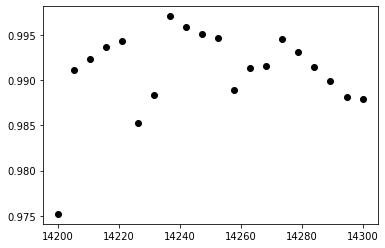

In [85]:
piTuneUp(np.linspace(1,40,41), 200, 14200, 14300, 20)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

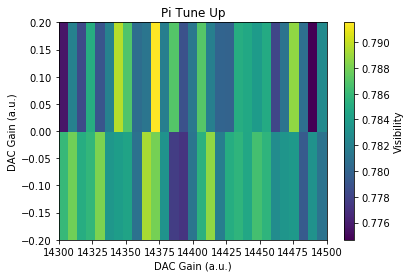

In [39]:
DRAGTuneUp(-0.2,0.2,3,14300,14500,30,15000, plot=True)

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

## T1 experiment

In [648]:
class T1Program(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.regwi(self.q_rp, self.r_wait, cfg["start"])

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2)
        
        for ch in [0]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        global phase
        phase=self.deg2reg(cfg["phase"])
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["pulse_length"], sigma=cfg["pulse_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])

        self.sync_all(self.us2cycles(500))
    
    def body(self):
        cfg=self.cfg
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["pi_gain"],
                                 waveform="drive")
        
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=phase)

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["qubit_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index

In [649]:
def T1(start, stop, expts, reps, plot=None, save=None, trial=None, collect=None):
    
    """
    Function to find T1
    
    :param start: starting delay [us]
    :param stop: maximum delay [us]
    :param expts: delay points (int)
    :param reps: # of reps to be averaged over
    
    :params plot, save, trial: see plotsave1d function above
    :param collect: if True, returns data. Returns T1 if False or None

    """
    
    step=(stop-start)/expts
    expt_cfg={ "start":start, "step":step, "expts":expts, "reps":reps,
            "relax_delay":250
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg} #combine configs
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    t1p=T1Program(soccfg, config)

    x_pts, avgi, avgq = t1p.acquire(soc, threshold=config["threshold"], load_pulses=True, progress=True, debug=False)
    
    subplot(111, title="T1 Experiment", xlabel=f"Time ($\mu s$)", ylabel="Qubit Population")
    results=np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr

    p_guess=[results[0]-results[-1],results[-1],10]

    p_optt, p_covt = curve_fit(exp_decay, x_pts, results, p0 = p_guess)
    p_errt = np.sqrt(np.diag(p_covt))

    fitfunc=exp_decay(x_pts,p_optt[0],p_optt[1],p_optt[2])
    fitvalues=p_optt
    fitvalueserr=p_errt
    
    plotsave1d(plot=plot, save=save, title="T1", trial=trial, xvar=np.linspace(start,start+step*expts,expts),
               xvarname="Delay (us)", ydata=results, ydataname="Qubit population", fitfunc=fitfunc, Shape="square pulse",
              Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)
    
    if collect:
        return results
    else:
        return p_optt[2]

  0%|          | 0/16000 [00:00<?, ?it/s]

{'T1': 17.54063787367432}

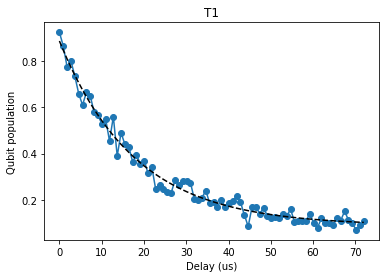

In [650]:
T1(0,0.9,80,200,plot=True, save=False, trial="with_threshold")

# 

# 

# 

# 

# 

In [651]:
class RamseyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.r_phase2 = 4
        self.r_phase=self.sreg(cfg["qubit_ch"], "phase")
        self.regwi(self.q_rp, self.r_wait, cfg["start"])
        self.regwi(self.q_rp, self.r_phase2, 0)
        
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        global phase
        phase=self.deg2reg(cfg["phase"])
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["pulse_length"], sigma=cfg["pulse_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])
        
        self.sync_all(self.us2cycles(0.2))
    
    def body(self):
        cfg=self.cfg
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=int(cfg["pi_gain"]/2), 
                                 waveform="drive")
        
        self.regwi(self.q_rp, self.r_phase, 0)
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.mathi(self.q_rp, self.r_phase, self.r_phase2,"+",0)
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)

        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05))

        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=phase)
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"])
        
        self.pulse(ch=cfg["qubit_ch"], t=0)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

        
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.cfg["step"]) # update the time between two π/2 pulses
        self.mathi(self.q_rp, self.r_phase2, self.r_phase2, '+', self.cfg["phase_step"]) # advance the phase of the LO for the second π/2 pulse

In [653]:
def T2(detuning, start, stop, p_step, expts, reps, plot=None, save=None, trial=None, collect=None):
    
    """
    Ramsey T2 Experiment
    
    :param detuning: detuning from drive frequency [MHz]
    :param start: starting delay [us]
    :param stop: maximum delay [us]
    :param p_step: phase step [degrees]
    :param expts: delay points (int)
    :param reps: # of reps to be averaged over (int)
    
    :param collect: if True, returns data. Returns T2 and actual detuning if False or None.
    """
    step=(stop-start)/expts
    expt_cfg={"start":soccfg.us2cycles(start), "step":soccfg.us2cycles(step), "phase_step": soccfg.deg2reg(p_step, gen_ch=2),
              "expts":expts, "reps": reps, "rounds": 1
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}
    config["f_ge"]-=detuning
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    t2p=RamseyProgram(soccfg, config)
    x_pts, avgi, avgq= t2p.acquire(soc,threshold=config["threshold"], load_pulses=True,progress=True, debug=False)

    results=np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr
    
    p_guess=[np.max(results)*0.8, 4*np.pi*detuning, 15, np.mean(results)]
    p_optt2, p_covt2 = curve_fit(t2fit, soccfg.cycles2us(x_pts), results, p0 = p_guess)
    p_errt2 = np.sqrt(np.diag(p_covt2))
    
    fitfunc=t2fit(soccfg.cycles2us(x_pts),p_optt2[0],p_optt2[1],p_optt2[2],p_optt2[3])
    fitvalues=p_optt2
    fitvalueserr=p_errt2
    
    plotsave1d(plot=plot, save=save, title="T2", trial=trial, xvar=soccfg.cycles2us(x_pts),
               xvarname="Delay (us)", ydata=results, ydataname="Qubit population", fitfunc=fitfunc, Shape="square pulse",
               Delta=delta, Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)
    Delta=p_optt2[1]/(2*np.pi)
    
    if collect:
        return results
    else:
        return {'T2':p_optt2[2], 'Detuning':Delta}

  0%|          | 0/120000 [00:00<?, ?it/s]

{'T2': 27.036779405837326, 'Delta': 0.14745898211174932}

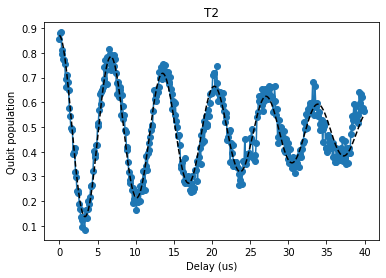

In [654]:
T2(0.15, 0, 0.1, 0.72, 400, 300, plot=True, save=False, trial="is it good now Yash")

# 

# 

# 

# 

# 

# 

# 

## Randomized benchmarking with Clifford gates

In [656]:
class summon_gate(AveragerProgram):
    """QICK function that, when called, will summon a specified sequence of gates. Requires tune-up before using

    Parameters (all fed in through AveragerProgram):
    ["gate_sequence"] (int array): series of gates [0-8] and pauses [9] 
    ["detuning"] (int): amount of detuning in MHz
    ["sync_time"] (float): wait time between gates in clock cycles
    ["wait_sequence"] (float array): series of floats, each of which corresponds to the length of the pause in ["gate_sequence"]
    """
    
    def initialize(self):
        self.declare_gen(ch=self.cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["f_res"], gen_ch=self.cfg["qubit_ch"])
        
        global phase
        phase=self.deg2reg(0, gen_ch=self.cfg["qubit_ch"])
        global negphase
        negphase=self.deg2reg(180, gen_ch=self.cfg["qubit_ch"])
        global yphase
        yphase=self.deg2reg(90, gen_ch=self.cfg["qubit_ch"])
        global negyphase
        negyphase=self.deg2reg(270, gen_ch=self.cfg["qubit_ch"])
        global resphase
        resphase=self.deg2reg(cfg["phase"])
        
        global f_res
        global f_ge

        f_res=self.freq2reg(self.cfg["f_res"]-self.cfg["detuning"], gen_ch=self.cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(self.cfg["f_ge"]-self.cfg["detuning"], gen_ch=self.cfg["qubit_ch"])
            
        self.add_DRAG(ch=self.cfg["qubit_ch"], name="drive", length=self.cfg["pulse_length"], 
                      sigma=self.cfg["pulse_length"]/4, delta=self.cfg["delta"], alpha=self.cfg["alpha"])
        self.add_gauss(ch=self.cfg["qubit_ch"], name="measure", sigma=self.cfg["res_sigma"]/4,
                       length=self.cfg["res_sigma"])
        
        self.synci(200)

    def body(self):
        for i in self.cfg["gate_sequence"]:    
            w_iter = 0
            if i == 9: #Pause in pulses
                self.sync_all(self.cfg["wait_sequence"][w_iter])
                w_iter += 1
            elif i == 0: #Identity gate
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, gain=0, style="arb",waveform="drive", phase=phase)
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 1: #X
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, gain=self.cfg["pi_gain"], style="arb", 
                                         waveform="drive", phase=phase)
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 2: #Y
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=yphase, gain=self.cfg["pi_gain"], 
                                         style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 3: #X2
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, gain=self.cfg["pi2_gain"], 
                                         style="arb", waveform="drive", phase=phase)
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 4: #Y2
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=yphase,
                                     gain=self.cfg["pi2_gain"], style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 5: #-X2
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=negphase, gain=self.cfg["pi2_gain"],
                                         style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 6: #-Y2
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=negyphase,
                                     gain=self.cfg["pi2_gain"], style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 7: #-X
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, gain=self.cfg["pi_gain"], phase=negphase, 
                                         style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 8: #-Y
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=negyphase, 
                                         gain=self.cfg["pi_gain"], style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            else:
                raise ValueError("'cfg[gate_sequence] value does not correspond to basic gate generator [0,8] or a pause 9 '")
        #Readout
        self.sync_all(self.cfg["drive_ro_delay"])

        self.set_pulse_registers(ch=self.cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res,
                                 length=self.cfg["res_length"], gain=self.cfg["res_gain"], phase=resphase)

        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])

        self.pulse(ch=self.cfg["qubit_ch"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [363]:
def gen_Clifford_seq(m, gate=None):
    """Function to generate array of gates for single-qubit gate randomized Clifford benchmarking

    Parameters:
    m (int): number of Cliffords
    gate (int): number corresponding to the interleaved gate. If None, then no interleaved gate
    """

    gates = [0,1,2,3,4,5,6,7,8]
    gates_inv = [0,7,8,5,6,3,4,1,2] ###### make sure this is actually the inverses according to the way summon_gate defines the gates
    cliffords = [[0],[1],[2],[2,1],[3,4],[3,6],[5,4],[5,6],[4,3],[4,5],[6,3],[6,5],
                 [3],[5],[4],[6],[5,4,3],[5,6,3],[1,4],[1,6],[2,3],[2,5],[3,4,3],[5,4,5]]
    
    gate_arr = [np.diag([1,1]), #I
                np.array([[0,-1j], [-1j,0]]), #X
                np.array([[0,-1], [1,0]]), #Y
                np.array([[1,-1j], [-1j,1]])/np.sqrt(2), #X2
                np.array([[1,-1], [1,1]])/np.sqrt(2), #Y2
                np.array([[1,1j], [1j,1]])/np.sqrt(2), #-X2
                np.array([[1,1], [-1,1]])/np.sqrt(2), #-Y2
                np.array([[0,1j], [1j,0]]), #-X
                np.array([[0,1], [-1,0]])] #-Y
    
    
    a = np.random.randint(0,23,int(m))
    gate_seq = []
    op_seq = gate_arr[0]
    
    for i in a:
        gate_seq.extend(cliffords[i])
        if gate is not None:
            gate_seq.append(gate)
    for j in gate_seq:
        op_seq = np.dot(op_seq, gate_arr[j])
    for g_try in range(24):
        checking_gate_seq = cliffords[g_try]
        check_gate = gate_arr[0]
        for k in checking_gate_seq:
            check_gate = np.dot(check_gate, gate_arr[k])
        gate_compare = np.dot(op_seq, check_gate)

        if np.abs(gate_compare[0,1])<0.01:
            gate_seq.extend(cliffords[g_try])
            break
            
    return gate_seq

In [379]:
def SingleGateRandFidelity(m_arr, gate, k, reps, save=None, trial=None):
    """Function to run single-qubit gate interleaved randomized Clifford benchmarking. Generates graphs for non-interleaved and interleaved runs.

    Parameters:
    m_arr (int array): series that specifies how many Cliffords are executed per trial
    gate (int): identity of the interleaved gate [0,8]
    k (int): how many different sequences are generated each trial (each entry in m_arr)
    reps (int): number of repetitions used in the sg.acquire() function
    save (bool): save the .csv and .pdf graphs? If None, nothing is saved
    trial (int): number by which the saved files are labeled
    """
    probs=[]   
    for m in tqdm(m_arr):
        prob=[]
        for ii in range(k):
            gates = gen_Clifford_seq(m)
            cliff_cfg={"reps":reps, "gate_sequence": gates, "wait_sequence": 0, 
                       "detuning":0, "sync_time":soccfg.us2cycles(0.01, gen_ch=2)} #10 ns time b/w gates is good for 16ns T1
            config={**hw_cfg,**readout_cfg,**qubit_cfg, **cliff_cfg,**dc_cfg}
            sg=summon_gate(soccfg, config)
            avgi, avgq=sg.acquire(soc, threshold=config["threshold"], load_pulses=True, progress=False,debug=False)
            prob.append(avgi[0]*config["readout_length"])
        probs.append(np.mean(prob))
        
    
    gprobs=[]
    for m in tqdm(m_arr):
        for ii in range(k):
            gprob=[]
            ggates = gen_Clifford_seq(m, gate)
            config["gate_sequence"]=ggates
            sg=summon_gate(soccfg, config)
            avgi, avgq=sg.acquire(soc, threshold=config["threshold"], load_pulses=True, progress=False,debug=False)
            gprob.append(avgi[0]*config["readout_length"])
        gprobs.append(np.mean(gprob))

    figure, axis = plt.subplots(1, 2, figsize=[16,8])
    axis[0].plot(m_arr*1.875, probs,'ko')
    axis[1].plot(m_arr*1.875, gprobs,'ko')
    

    p_guess = [-0.5,0.9,0.5]
    p_opt, p_cov = curve_fit(p_decay, m_arr*1.875, probs, p0 = p_guess, bounds=((-0.7, 0.1, 0.3), (-0.3, 1, 0.7)))
    p_err = np.sqrt(p_cov)

    gp_opt, gp_cov = curve_fit(p_decay, m_arr*1.875, gprobs, p0 = p_guess, bounds=((-0.7, 0.1, 0.3), (-0.3, 1, 0.7)))
    gp_err = np.sqrt(gp_cov)


    p = p_opt[1]
    p_inter = gp_opt[1]
    rand_fidelity = 1 - ((1-p)/(2*1.875))
    inter_fidelity = (1+p_inter/p)/2



    xfit = np.linspace(min(m_arr)*1.875,max(m_arr)*1.875,1000)
    yfit = p_decay(xfit, p_opt[0],p_opt[1],p_opt[2])

    axis[0].plot(xfit, yfit,'-')
    axis[0].set_xlabel("Number of Cliffords (m)")
    axis[0].set_ylabel("Qubit population")
    axis[0].set_title("Cliffords")
    
    gyfit = p_decay(xfit, gp_opt[0],gp_opt[1],gp_opt[2])
    axis[1].plot(xfit, gyfit,'-')
    axis[1].set_xlabel("Number of Cliffords (m)")
    axis[1].set_ylabel("Qubit population")
    axis[1].set_title("Interleaved Gate + Cliffords")

    print("Randomized clifford benchmarking fidelity is: " + str(rand_fidelity))
    print("Interleaved clifford benchmarking fidelity for the " + str(gatelist[int(gate)]) + " gate is: " + str(inter_fidelity))
    
    if save is not None and save:
        today=date.today()
        plt.savefig("images/Stark-Rand_Benchmarking-{}-{}.pdf".format(today, trial))
        
        with open('measurement_data/Stark-Rand_Benchmarking-{}-{}.csv'.format(today, trial), 'w') as f:
            writer = csv.writer(f)
            writer.writerows([["Randomized benchmarking of " +str(gatelist[int(gate)]) + " gate"],[]])
            writer.writerow(["Randomized fidelity: {}".format(rand_fidelity)])
            writer.writerow(["Interleaved fidelity: {}".format(inter_fidelity)])
                    
            df=pd.DataFrame(np.vstack([probs, gprobs]).T, index=m_arr)
            df.to_csv('measurement_data/Stark-Rand_Benchmarking-{}-{}.csv'.format(today, trial), mode='a', header=False)
    return probs, gprobs

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.9982625260854906
Interleaved clifford benchmarking fidelity for the I gate is: 0.9989262310395978


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.998245631965179
Interleaved clifford benchmarking fidelity for the X gate is: 0.9984436054271624


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.9982037721823235
Interleaved clifford benchmarking fidelity for the Y gate is: 0.9966334217021449


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.9980482489170128
Interleaved clifford benchmarking fidelity for the X2 gate is: 0.9990844835109569


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.9981733373257647
Interleaved clifford benchmarking fidelity for the Y2 gate is: 0.9988841303344629


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.9980942899409282
Interleaved clifford benchmarking fidelity for the -X2 gate is: 0.9979071040926323


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.9981172614453935
Interleaved clifford benchmarking fidelity for the -Y2 gate is: 0.9967358994849314


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.9982194524299256
Interleaved clifford benchmarking fidelity for the -X gate is: 0.9950654264180039


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.998081314349877
Interleaved clifford benchmarking fidelity for the -Y gate is: 0.9931738113608601


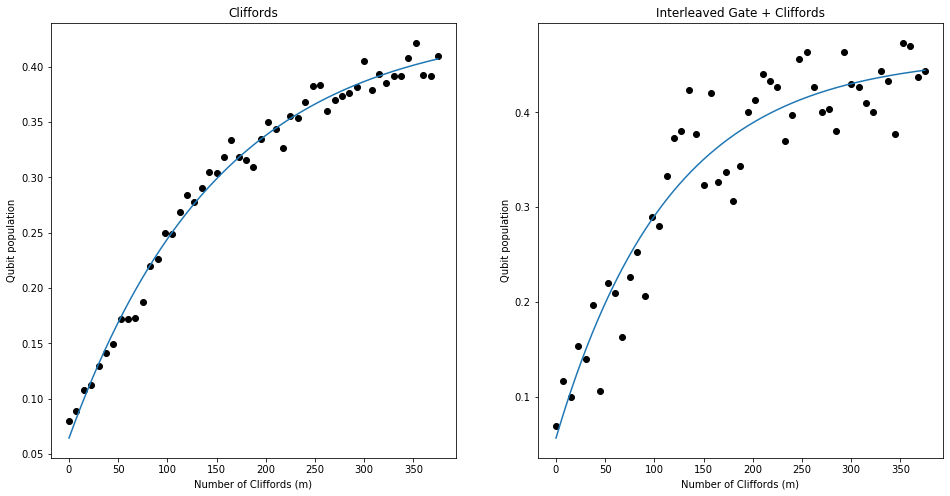

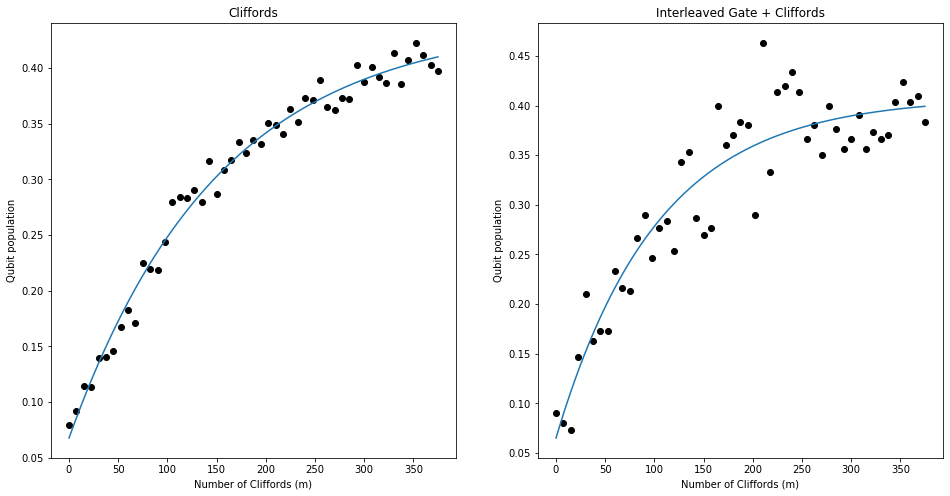

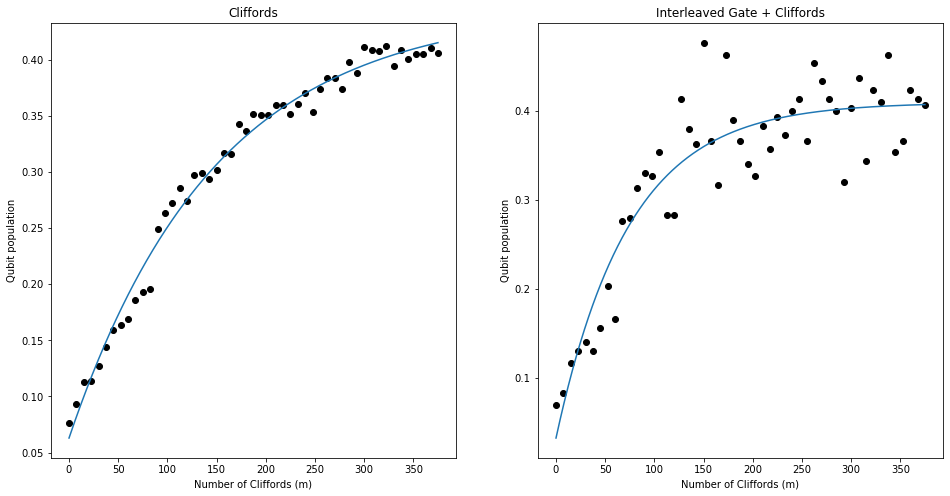

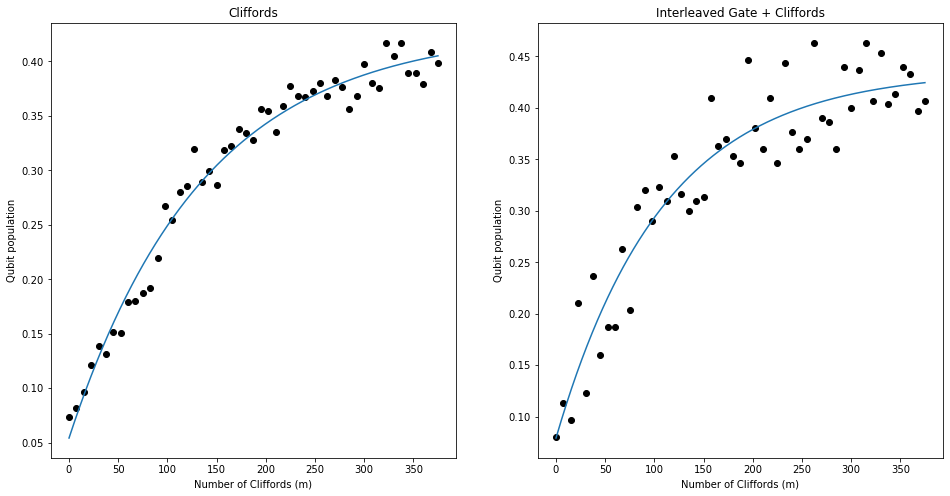

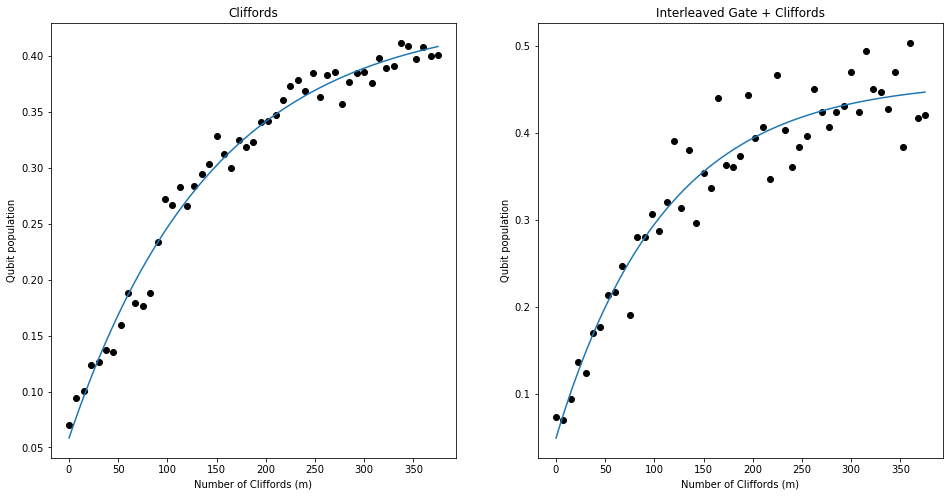

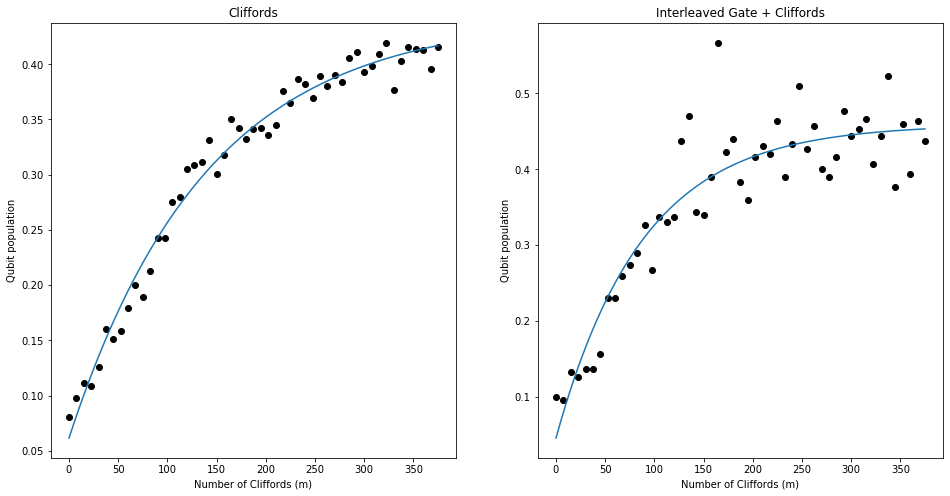

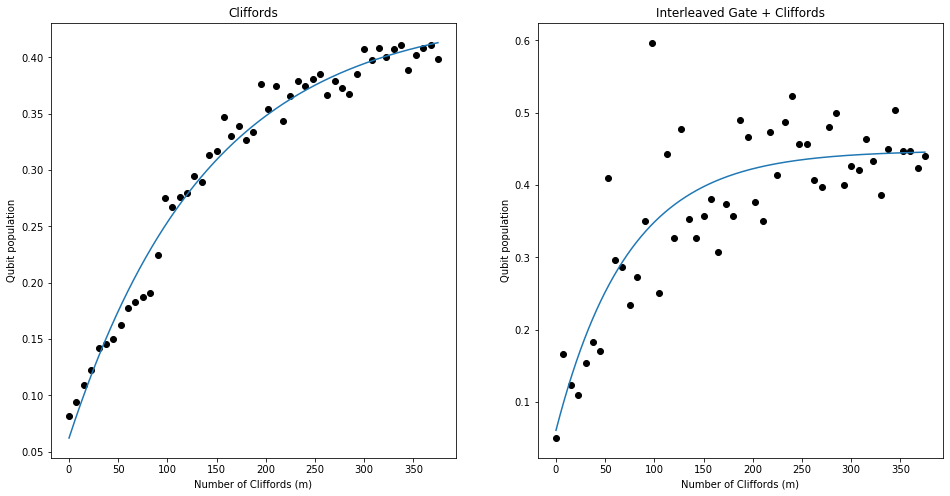

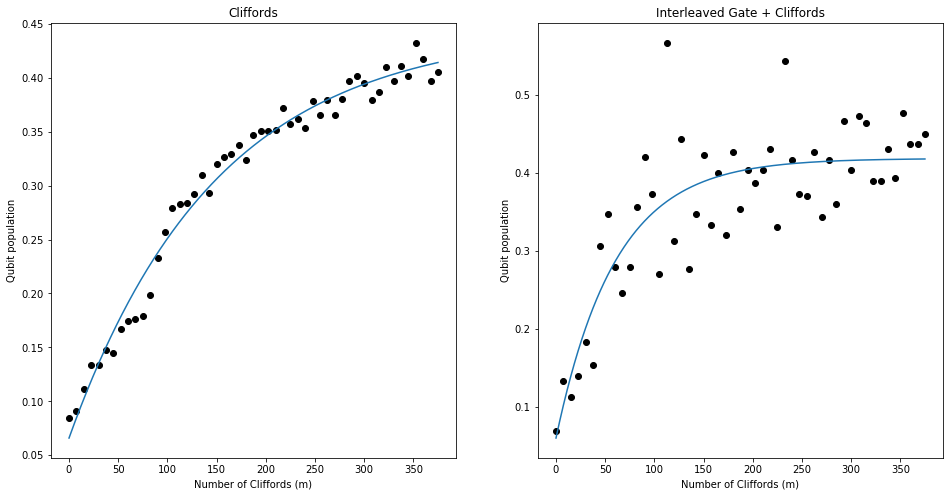

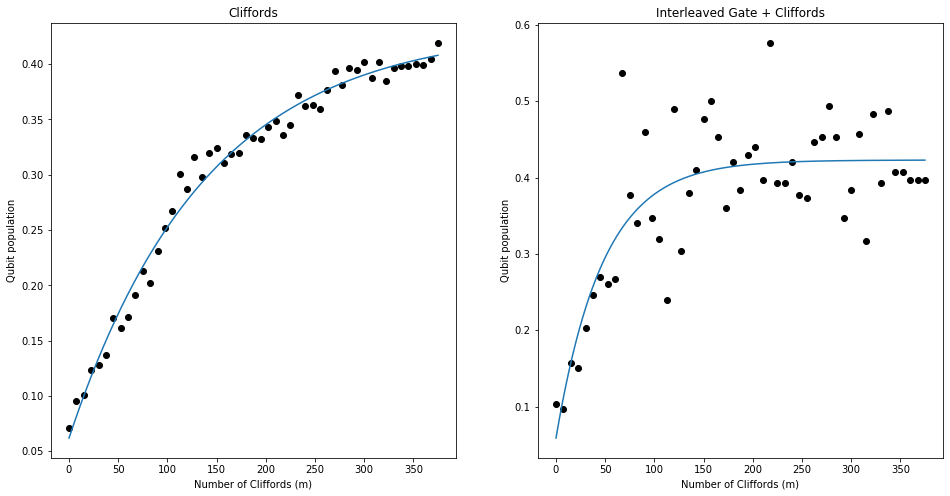

In [380]:
m_arr = np.linspace(0, 200, 51) #m should be less than 200
gatelist = ["I","X","Y","X2","Y2","-X2","-Y2","-X","-Y"]

for i in range(9):
    probs, gprobs = SingleGateRandFidelity(m_arr, i, 20, 300, save=True, trial="Best one {}".format(i))

In [533]:
def DRAGprogram(m_arr, alpha, k, reps):
    probs=[]   
    for m in tqdm(m_arr):
        prob=[]
        for ii in range(k):
            gates = gen_Clifford_seq(m)
            cliff_cfg={"reps":reps, "gate_sequence": gates, "wait_sequence": 0, 
                       "detuning":0, "sync_time":soccfg.us2cycles(0.01, gen_ch=2)} #10 ns time b/w gates is good for 16ns T1
            config={**hw_cfg,**readout_cfg,**qubit_cfg, **cliff_cfg,**dc_cfg}
            config["alpha"]=alpha
            sg=summon_gate(soccfg, config)
            avgi, avgq=sg.acquire(soc, threshold=config["threshold"], load_pulses=True, progress=False,debug=False)
            prob.append(avgi[0]*config["readout_length"])
        probs.append(np.mean(prob))
    
    p_guess = [-0.5,0.9,0.5]
    p_opt, p_cov = curve_fit(p_decay, m_arr, probs, p0 = p_guess, bounds=((-0.7, 0.1, 0.3), (-0.3, 1, 0.7)))
    p_err = np.sqrt(p_cov)
    
    plt.plot(m_arr, probs,'ko')
    
    xfit = np.linspace(min(m_arr),max(m_arr),1000)
    yfit = p_decay(xfit, p_opt[0],p_opt[1],p_opt[2])

    plt.plot(xfit, yfit,'-')
    
    p = p_opt[1]
    rand_fidelity = 1 - ((1-p)/(2*1.875))
    
    return rand_fidelity

  0%|          | 0/5 [00:00<?, ?it/s]

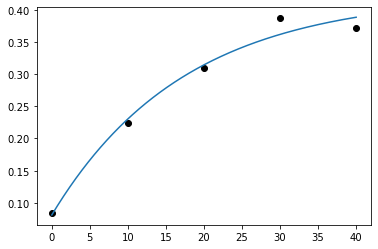

In [536]:
m_arr = np.linspace(0,40,5)
DRAGprogram(m_arr, 0, 10, 200)

#ef DRAG_optimization()

# 

# 

# 

## Hahn Echo

In [399]:
def HahnEcho(tau_arr, tau_max, reps, detuning, save=None, trial=None):
    """Function to run a Hahn Echo experiment. Generates graphs

    Parameters:
    tau_arr (float array): series from (0,1) that, when multiplied by tau_max, gives the total time per each Hahn echo experiment
    tau_max (int): maximum length of Hahn echo run in us
    reps (int): number of repetitions used in the sg.acquire() function
    detuning (float): detuning of qubit in MHz
    save (bool): save the .csv and .pdf graphs? If None, nothing is saved
    trial (int): number by which the saved files are labeled
    """
    probs = []
    gates = [3,9,1,9,3] #Hahn sequence: X2, I, X, I, X2
    for tau in tqdm(soccfg.us2cycles(tau_max, gen_ch=2)*tau_arr):

            hahn_cfg={"reps":reps, "gate_sequence": gates, "wait_sequence": [tau/2, tau/2], "detuning":detuning, 
                      "sync_time":soccfg.us2cycles(0.01, gen_ch=2)}
            
            config={**hw_cfg,**readout_cfg,**qubit_cfg, **hahn_cfg,**dc_cfg}
            he=summon_gate(soccfg, config)
            avgi, avgq=he.acquire(soc, threshold=config["threshold"], load_pulses=True, 
                                  progress=False,debug=False)
            probs.append((avgi[0]*config["readout_length"])[0])
    
    p_guess = [0,0,30]
    p_opt, p_cov = curve_fit(exp_decay, tau_arr*tau_max, probs, p0 = p_guess)
    p_err = np.sqrt(np.diag(p_cov))
    print(p_err)
    
    fig, ax = plt.subplots(figsize=[12,8])
    ax.plot(tau_arr*tau_max, probs, 'ko')
    xfit = np.linspace(0,tau_max,1000)
    yfit = exp_decay(xfit, p_opt[0], p_opt[1], p_opt[2])
    ax.plot(xfit, yfit,'-')
    
    plt.xlabel("Wait time (us)")
    plt.ylabel("Qubit population")
    plt.title("Hahn Echo")
    
    #plt.savefig("Hahn Echo test")
    
    print("Hahn Echo T_2e " + str(p_opt[2]) + " +/- " + str(p_err[2]))
    
#     plotsave1d(plot=plot, save=save, title="Hahn Echo", trial=trial, xvar=tau_arr*tau_max,
#               xvarname="Wait time (us)", ydata=probs, ydataname="Qubit population", fitfunc=yfit, Shape="square pulse",
#               Fitvalues=p_opt[2], Fitvalueserr=p_err[2])

  0%|          | 0/100 [00:00<?, ?it/s]

[0.00270926 0.00072083 0.39509001]
Hahn Echo T_2e 31.656478549141625 +/- 0.3950900101117205


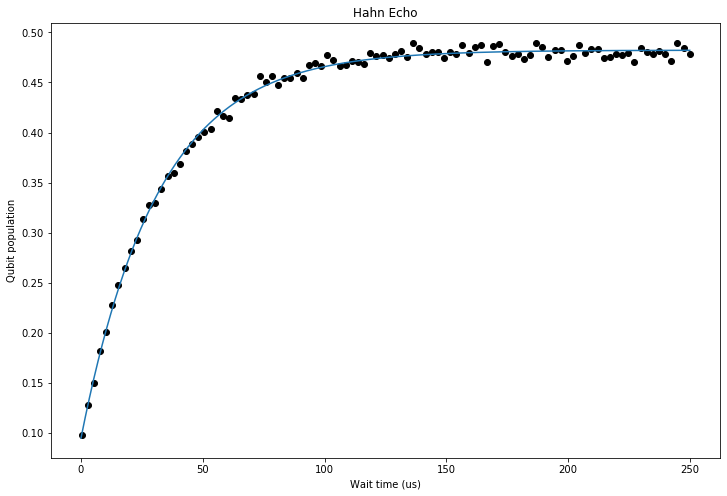

In [400]:
#actual numbers should be k ~20, tau goes up to 250 us.
tau_arr = np.linspace(0.001,1,100)
tau_max = 250 #in us
reps = 10000
detuning = 0 

t2 = HahnEcho(tau_arr, tau_max, reps, detuning)

# 

# 

# 

# CPMG

In [552]:
def CPMG(tau_arr, tau_max, reps, detuning, gate_arr):
    """Function to run a CPMG experiment. Generates CPMG graph and "Hahn echo" graphs for each run

    Parameters:
    tau_arr (float array): series from (0,1) that, when multiplied by tau_max, gives the total time per each Hahn echo experiment
    tau_max (int): maximum length of Hahn echo run in us
    gate_arr (int array): series with each entry reflecting how many X/2 gates there are
    reps (int): number of repetitions used in the sg.acquire() function
    detuning (float): detuning of qubit in MHz
    save (bool): save the .csv and .pdf graphs? If None, nothing is saved
    trial (int): number by which the saved files are labeled
    """
    t2s = []
    t2_errs = []
    for n in tqdm(gate_arr):
        n = int(n)
        tau_probs = []
        gates = np.array([3] + [9,1]*n + [9,3]) #Gandalf optimized 八(＾□＾*)
        
        for tau in tau_arr*soccfg.us2cycles(tau_max, gen_ch=2):
            wait_seq = np.array([tau/(2*n)] + [tau/n]*(n-1) + [tau/(2*n)])
            cpmg_cfg={"reps":reps, "gate_sequence": gates, "wait_sequence": wait_seq, "detuning":detuning, 
                      "sync_time":soccfg.us2cycles(0.01, gen_ch=2)}
            config={**hw_cfg,**readout_cfg,**qubit_cfg, **cpmg_cfg,**dc_cfg}
            he=summon_gate(soccfg, config)
            avgi, avgq=he.acquire(soc, threshold=config["threshold"], load_pulses=True, 
                                  progress=False,debug=False)
            tau_probs.append((avgi[0]*config["readout_length"])[0])
    
        p_guess = [0,0,30]
        p_opt, p_cov = curve_fit(exp_decay, tau_arr*tau_max, tau_probs, p0 = p_guess)
        p_err = np.sqrt(p_cov)
        t2s.append(p_opt[2])
        t2_errs.append(p_err[2])
        
        fig, ax = plt.subplots()
        t2string = "T2 = " + str(p_opt[2])
        ax.plot(tau_arr*tau_max, tau_probs, 'ko', label=t2string)
        xfit = np.linspace(0,tau_max,1000)
        yfit = exp_decay(xfit, p_opt[0], p_opt[1], p_opt[2])
        ax.plot(xfit, yfit,'-')
        plt.xlabel("Wait time (us)")
        plt.ylabel("Qubit population")
        plt.legend()
    
    print(t2s)
    fig, ax = plt.subplots(figsize=[12,8])
    ax.plot(gate_arr, t2s, 'ko')
    plt.xlabel("Wait time (us)")
    plt.ylabel("T2 time")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("CPMG Sequence")
    plt.savefig("CPMG test")

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: could not broadcast input array from shape (4308954,) into shape (16384,)

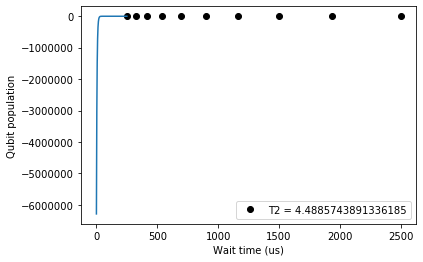

In [553]:
#actual params for experiments in comments
tau_arr = np.logspace(0.001,1,10) #0.001, 1, 100
tau_max = 250 #in us
reps = 3000 #3000
detuning = 0 
gate_arr = np.logspace(1,40,10) #1, 1000, 100

t2 = CPMG(tau_arr, tau_max, reps, detuning, gate_arr)

## 

## Active reset

In [1065]:
class ActiveResetProgram(AveragerProgram):   
    
    def initialize(self):
        cfg=self.cfg      
        
        self.regwi(0,1,0)

        self.r_thresh = 6
        self.regwi(0,self.r_thresh,int(cfg["threshold"]*cfg["readout_length"]))
        
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2)
        self.declare_readout(ch=0, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        global f_res
        global f_ge
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        global phase
        phase=self.deg2reg(cfg["phase"])
        
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["pulse_length"], sigma=cfg["pulse_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        cfg=self.cfg
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", waveform="drive", freq=f_ge, gain=cfg["qubit_gain"], phase=0)
        self.pulse(ch=cfg["qubit_ch"])
        self.sync_all(self.us2cycles(0.05))
        
        
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=phase)
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"])
        
        self.pulse(ch=cfg["qubit_ch"])
        self.sync_all(self.us2cycles(10))
        
        self.read(0,0,"lower",2)
        self.read(0,0,"upper",3)
        self.mathi(0,self.r_thresh,self.r_thresh,'+',10000)
        self.mathi(0,2,2,'+',10000)
        self.mathi(0,3,3,'+',10000)
        self.condj(0,2,'<',self.r_thresh,'after_reset')
        
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", waveform="drive", freq=f_ge, gain=cfg["pi_gain"], phase=0)
        self.pulse(ch=cfg["qubit_ch"])
        self.sync_all(self.us2cycles(0.05))

        self.label('after_reset')

        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                  gain=cfg["res_gain"], phase=phase)
        self.measure(pulse_ch=self.cfg["qubit_ch"], 
              adcs=[0],
              adc_trig_offset=self.cfg["adc_trig_offset"],
              wait=True,
              syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [1066]:
def ActiveReset(start, stop, expts, reps):
    expt_cfg={"start":start, "stop":stop, "expts":expts, "reps": reps
       }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg,**dc_cfg}       

    expt_pts=np.linspace(start, stop, expts).astype(int)
    pre_reset=[]
    post_reset=[]
    for i in tqdm(expt_pts):
        config["qubit_gain"]=i
        areset=ActiveResetProgram(soccfg, config)
        avgi, avgq = areset.acquire(soc, readouts_per_experiment=2, threshold=config["threshold"], load_pulses=True, progress=False)
        pre_reset.append(avgi[0][0]*config["readout_length"])
        post_reset.append(avgi[0][1]*config["readout_length"])
    
    subplot(111,title="Active Reset", xlabel="Pulse Amplitude", ylabel="Qubit Population")
    plot(expt_pts,pre_reset,'o-', label="pre-reset")
    plot(expt_pts,post_reset, 'o-', label="post-reset")
    legend();

  0%|          | 0/100 [00:00<?, ?it/s]

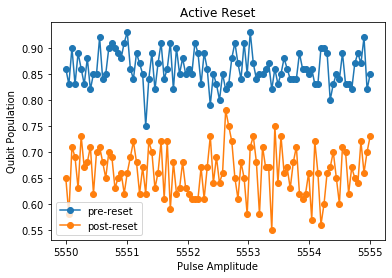

In [1067]:
ActiveReset(5550, 5555, 100, 100)